<a href="https://colab.research.google.com/github/mkbahk/AmazonBraket/blob/main/QuantumApplicationAlgorithm_VAQ_VQE(Ansatz_TowLocal_expressivity)_mkbahk_20251208.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Python 3.9 ~ 3.11 환경에서 아래 순서대로 설치
!pip install qiskit[visualization]==1.2.4
!pip install qiskit-aer==0.15.1
!pip install qiskit-algorithms==0.3.1
!pip install qiskit-nature[pyscf]==0.7.2
!pip install pyscf==2.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 16.8 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=f222e9caae9dd4818aad031405261488719629cfc2f3be4d8b82f903eaa0d2bf
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 66.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.5/310.5 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
"""
VQE (Variational Quantum Eigensolver) 구현
수소 분자(H2)의 바닥 상태 에너지 계산
"""

import numpy as np
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver

from qiskit_nature.second_q.mappers import JordanWignerMapper, ParityMapper, BravyiKitaevMapper, TaperedQubitMapper, DirectMapper, QubitMapper

from qiskit_nature.second_q.transformers import ActiveSpaceTransformer

from qiskit.primitives import Estimator
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP, COBYLA
from qiskit.circuit.library import TwoLocal, EfficientSU2, RealAmplitudes, ExcitationPreserving, PauliTwoDesign, NLocal
from qiskit_aer import AerSimulator

print("=" * 60)
print("VQE를 이용한 분자 에너지 계산")
print("=" * 60)

VQE를 이용한 분자 에너지 계산


In [4]:
# 1. 분자 (구조)정의 (H2 분자)
print("\n[1단계] 분자 구조 정의")
print("-" * 60)

# 수소 분자 정의 (원자간 거리: 0.735 Angstrom)
molecule = "H 0.0 0.0 0.0; H 0.0 0.0 0.735"
driver = PySCFDriver(
    atom=molecule,
    basis="sto3g",  # 기저 함수
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM
)

print(f"분자: H2 (수소 분자)")
print(f"원자간 거리: 0.735 Å")
print(f"기저 함수: STO-3G")


[1단계] 분자 구조 정의
------------------------------------------------------------
분자: H2 (수소 분자)
원자간 거리: 0.735 Å
기저 함수: STO-3G


In [5]:
# 2. 전자 구조 문제 설정
print("\n[2단계] 전자 구조 문제 설정")
print("-" * 60)

problem = driver.run()
print(f"분자 궤도 개수: {problem.num_spatial_orbitals}")
print(f"전자 개수: {problem.num_particles}")

# Hamiltonian 얻기
hamiltonian = problem.hamiltonian.second_q_op()


[2단계] 전자 구조 문제 설정
------------------------------------------------------------
분자 궤도 개수: 2
전자 개수: (1, 1)


In [6]:
# 3. Qubit Mapping (Jordan-Wigner 변환)
print("\n[3단계] Qubit Mapping")
print("-" * 60)

mapper = JordanWignerMapper()
#mapper = ParityMapper()
#mapper = BravyiKitaevMapper()
#mapper = TaperedQubitMapper(ParityMapper())
#mapper = DirectMapper()
#mapper = QubitMapper() //에러발생

qubit_op = mapper.map(hamiltonian)

print(f"필요한 큐비트 개수: {qubit_op.num_qubits}")
print(f"Pauli 항의 개수: {len(qubit_op)}")


[3단계] Qubit Mapping
------------------------------------------------------------
필요한 큐비트 개수: 4
Pauli 항의 개수: 15


In [29]:
# 4. Ansatz 정의 (양자 회로)
print("\n[4단계] Ansatz (Variational Form) 정의")
print("-" * 60)

num_qubits = qubit_op.num_qubits

# 가장 표준적인 형태 (논문의 90%가 이걸 씀)
#ansatz = EfficientSU2(num_qubits=num_qubits, reps=3, entanglement='linear', insert_barriers=True)

# TwoLocal ansatz 사용
#ansatz = TwoLocal(num_qubits=num_qubits, rotation_blocks=['ry', 'rz'], entanglement_blocks='cz', entanglement='linear', reps=2, insert_barriers=True)
#print(f"Ansatz 타입: TwoLocal \n회전 게이트: RY, RZ\n얽힘 게이트: CZ \n반복 횟수: 2 \n파라미터 개수: {ansatz.num_parameters} ")



# 실수 파라미터만 쓰고 싶을 때
#ansatz = RealAmplitudes(num_qubits=num_qubits, reps=3, entanglement='linear')

# expressivity를 더 높이고 싶을 때 (작은 시스템)
ansatz = TwoLocal(num_qubits=num_qubits, rotation_blocks=['ry', 'rz'], entanglement_blocks='cx', entanglement='sca', reps=5)


[4단계] Ansatz (Variational Form) 정의
------------------------------------------------------------


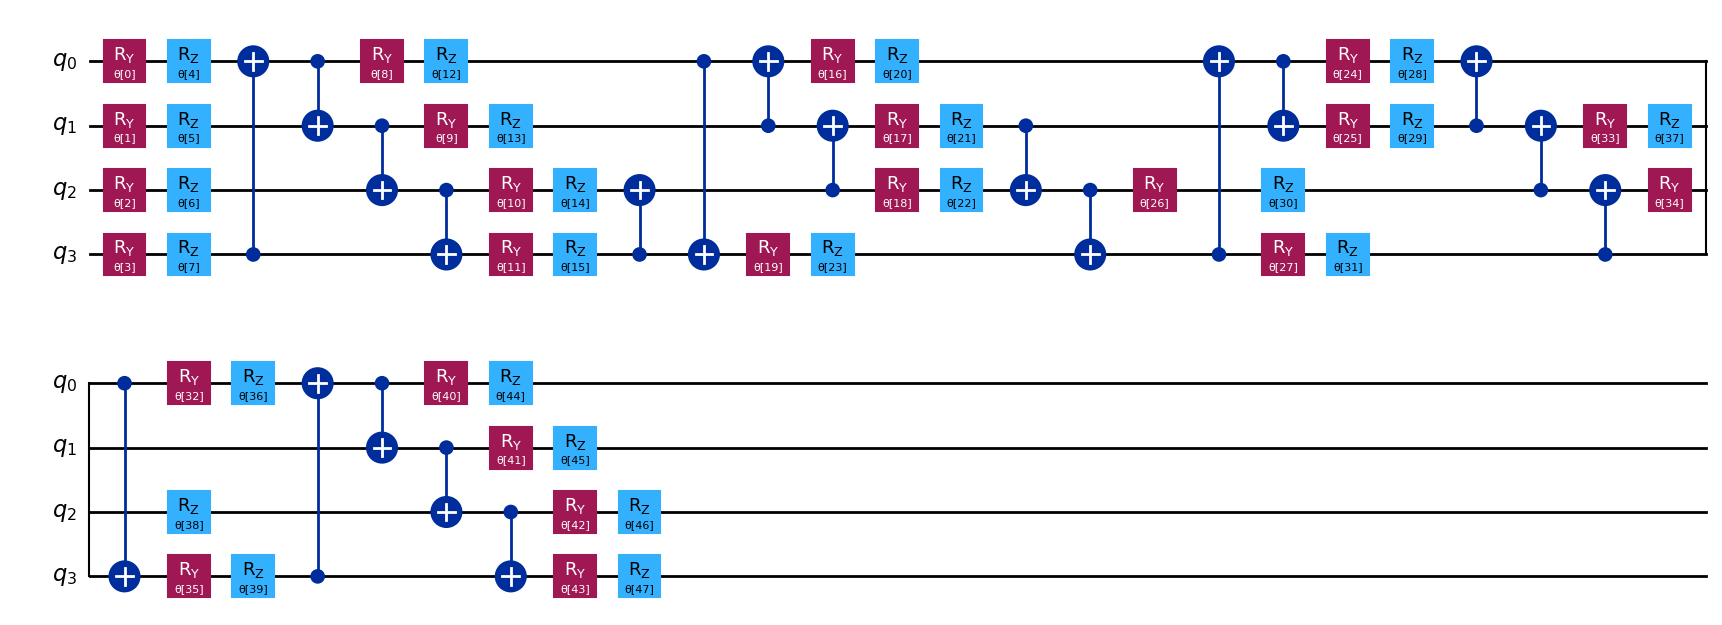

In [30]:
ansatz.decompose().draw("mpl")

In [31]:
# 5. 시뮬레이터 설정
print("\n[5단계] 양자 시뮬레이터 설정")
print("-" * 60)

backend = AerSimulator()
print(f"백엔드: {backend.name}")

# Estimator 설정 (Qiskit Primitives)
estimator = Estimator()


[5단계] 양자 시뮬레이터 설정
------------------------------------------------------------
백엔드: aer_simulator


In [32]:
# 6. Optimizer 설정
print("\n[6단계] Classical Optimizer 설정")
print("-" * 60)

optimizer = SLSQP(maxiter=4082)
print(f"Optimizer: SLSQP")
print(f"최대 반복 횟수: 4082")


[6단계] Classical Optimizer 설정
------------------------------------------------------------
Optimizer: SLSQP
최대 반복 횟수: 4082


In [33]:
# 7. VQE 실행
print("\n[7단계] VQE 알고리즘 실행")
print("-" * 60)
print("최적화 진행...")

# 초기 파라미터 설정
initial_point = np.random.random(ansatz.num_parameters)

#수렴과정을 그래프로 그리기 위해 중간 상태 보관
cost_history = []
def store_intermediate_result(eval_count, parameters, mean, std):
  print(eval_count," 단계: ", mean)
  cost_history.append(mean)
###def

# VQE 인스턴스 생성
vqe = VQE(
    estimator=estimator,
    ansatz=ansatz,
    optimizer=optimizer,
    initial_point=initial_point,
    callback=store_intermediate_result
)

# VQE 실행
result = vqe.compute_minimum_eigenvalue(qubit_op)

print("최적화 완료!!!")


[7단계] VQE 알고리즘 실행
------------------------------------------------------------
최적화 진행...
1  단계:  -0.7982623352091114
2  단계:  -0.7982623368186885
3  단계:  -0.7982623368536778
4  단계:  -0.7982623358971829
5  단계:  -0.7982623365215293
6  단계:  -0.7982623357347998
7  단계:  -0.7982623354870033
8  단계:  -0.7982623352089524
9  단계:  -0.7982623353348215
10  단계:  -0.7982623333458815
11  단계:  -0.7982623326028101
12  단계:  -0.7982623381531406
13  단계:  -0.7982623378057571
14  단계:  -0.798262336475142
15  단계:  -0.7982623361460046
16  단계:  -0.7982623348613643
17  단계:  -0.7982623360848785
18  단계:  -0.7982623350640438
19  단계:  -0.7982623315696189
20  단계:  -0.7982623382605716
21  단계:  -0.7982623374384566
22  단계:  -0.7982623356253038
23  단계:  -0.7982623358073316
24  단계:  -0.798262333078252
25  단계:  -0.7982623358102817
26  단계:  -0.7982623350784863
27  단계:  -0.7982623385194264
28  단계:  -0.7982623338018222
29  단계:  -0.7982623346559826
30  단계:  -0.7982623340633497
31  단계:  -0.7982623344889327
32  단계:  -0.7982623341

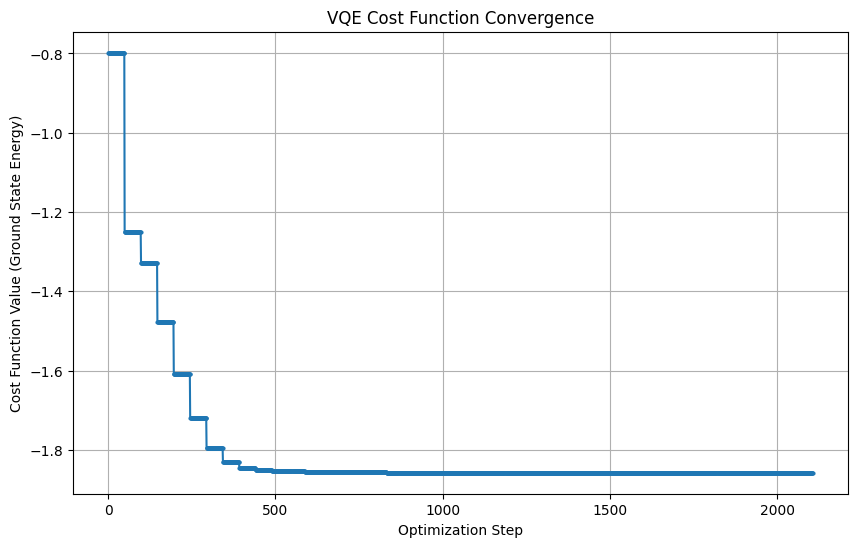

In [34]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(cost_history, marker='o', linestyle='-', markersize=2)
plt.title('VQE Cost Function Convergence')
plt.xlabel('Optimization Step')
plt.ylabel('Cost Function Value (Ground State Energy)')
plt.grid(True)
plt.show()

In [35]:
# 8. 결과 출력
print("\n" + "=" * 60)
print("VQE 결과")
print("=" * 60)

print(f"\n최적 에너지 (VQE): {result.eigenvalue.real:.6f} Hartree")
print(f"최적 파라미터 개수: {len(result.optimal_point)}")
print(f"Optimizer 평가 횟수: {result.cost_function_evals}")


VQE 결과

최적 에너지 (VQE): -1.857264 Hartree
최적 파라미터 개수: 48
Optimizer 평가 횟수: 2108


In [36]:
# 9. 정확한 해와 비교 (Classical 계산)
print("\n[비교] Classical Exact Eigensolver")
print("-" * 60)

from qiskit_algorithms import NumPyMinimumEigensolver

numpy_solver = NumPyMinimumEigensolver()
exact_result = numpy_solver.compute_minimum_eigenvalue(qubit_op)

print(f"정확한 에너지: {exact_result.eigenvalue.real:.6f} Hartree")

# 오차 계산
error = abs(result.eigenvalue.real - exact_result.eigenvalue.real)
print(f"\n에너지 오차: {error:.6f} Hartree")
print(f"상대 오차: {(error / abs(exact_result.eigenvalue.real)) * 100:.4f}%")


[비교] Classical Exact Eigensolver
------------------------------------------------------------
정확한 에너지: -1.857275 Hartree

에너지 오차: 0.000011 Hartree
상대 오차: 0.0006%


In [37]:
# 10. 추가 정보
print("\n" + "=" * 60)
print("추가 정보")
print("=" * 60)

# 에너지를 다른 단위로 변환 (Hartree to eV)
hartree_to_ev = 27.211386245988
vqe_energy_ev = result.eigenvalue.real * hartree_to_ev
exact_energy_ev = exact_result.eigenvalue.real * hartree_to_ev

print(f"\nVQE 에너지: {vqe_energy_ev:.6f} eV")
print(f"정확한 에너지: {exact_energy_ev:.6f} eV")

print("\n" + "=" * 60)
print("계산 완료!")
print("=" * 60)


추가 정보

VQE 에너지: -50.538735 eV
정확한 에너지: -50.539028 eV

계산 완료!
